In [26]:
import os
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
from torchvision import datasets, transforms
device = "cuda" if torch.cuda.is_available() else "cpu"


In [27]:
images_path = '/kaggle/input/itstep-exam-2/ship_images'
csv_path = '/kaggle/input/itstep-exam-2/ship_segmentations.csv'

In [28]:
df = pd.read_csv(csv_path)
print("Розмір датафрейму:", df.shape)
print(df.head())


Розмір датафрейму: (231723, 2)
         ImageId                                      EncodedPixels
0  00003e153.jpg                                                NaN
1  0001124c7.jpg                                                NaN
2  000155de5.jpg  264661 17 265429 33 266197 33 266965 33 267733...
3  000194a2d.jpg  360486 1 361252 4 362019 5 362785 8 363552 10 ...
4  000194a2d.jpg  51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


In [29]:
import pandas as pd
import matplotlib.pyplot as plt

# Завантаження CSV з даними
df = pd.read_csv('/kaggle/input/itstep-exam-2/ship_segmentations.csv')

# Перевірка наявних колонок
# print(df.head())

# Очищення даних від рядків з NaN у стовпці EncodedPixels
df_cleaned = df.dropna(subset=['EncodedPixels'])

# Підрахунок кількості кораблів на кожному зображенні
ship_counts = df_cleaned.groupby('ImageId').size()

# Виведення кількості кораблів для кожного зображення
print(ship_counts)


ImageId
000155de5.jpg    1
000194a2d.jpg    5
00021ddc3.jpg    9
0002756f7.jpg    2
00031f145.jpg    1
                ..
fff77c602.jpg    1
fff909871.jpg    1
fffcb6464.jpg    1
fffd924fb.jpg    2
fffdd2377.jpg    1
Length: 42556, dtype: int64


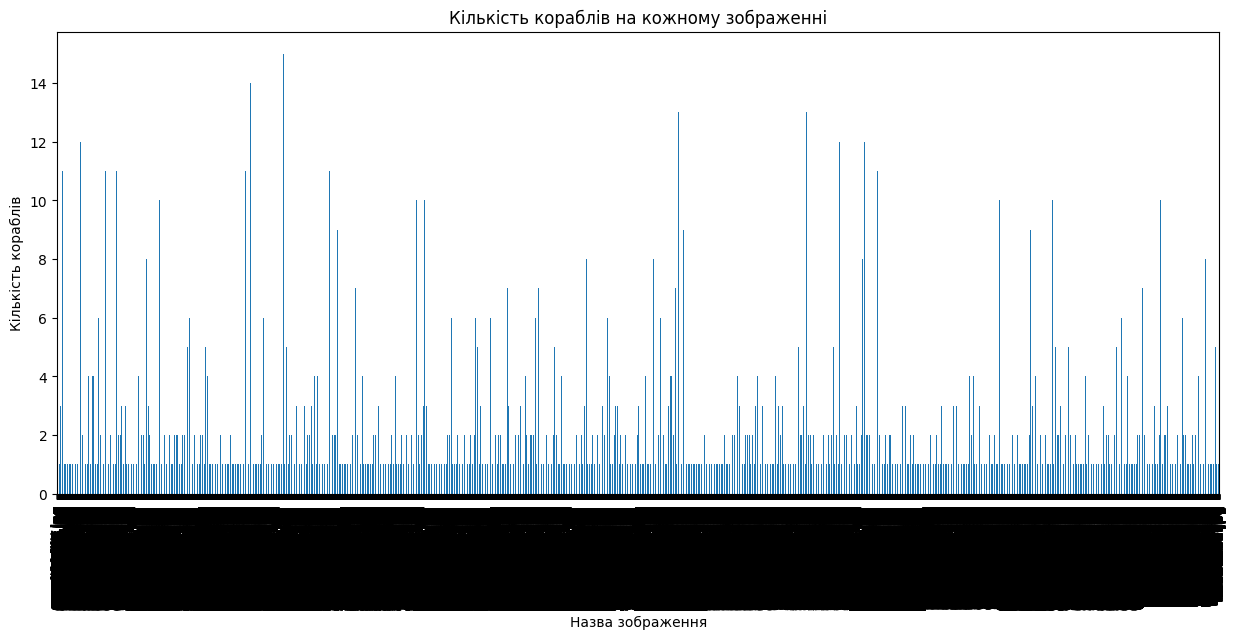

In [30]:
# Візуалізація кількості кораблів на кожному зображенні
plt.figure(figsize=(15, 6))
ship_counts.plot(kind='bar')
plt.title('Кількість кораблів на кожному зображенні')
plt.xlabel('Назва зображення')
plt.ylabel('Кількість кораблів')
plt.xticks(rotation=90)
plt.show()

In [31]:
df_cleaned

,ImageId,EncodedPixels
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...
5,000194a2d.jpg,198320 10 199088 10 199856 10 200624 10 201392...
6,000194a2d.jpg,55683 1 56451 1 57219 1 57987 1 58755 1 59523 ...
...,...,...
231694,fff909871.jpg,441057 2 441825 4 442592 7 443360 9 444128 11 ...
231709,fffcb6464.jpg,222782 4 223550 10 224318 14 225086 14 225854 ...
231712,fffd924fb.jpg,110011 5 110779 5 111547 5 112315 5 113083 5 1...
231713,fffd924fb.jpg,198440 8 199208 8 199976 8 200744 8 201512 8 2...


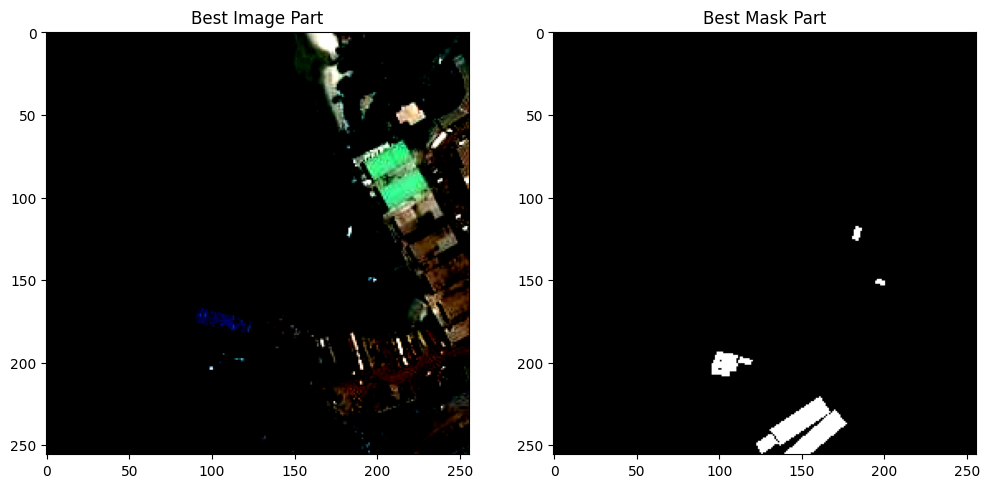

In [49]:
import numpy as np
import pandas as pd
import cv2
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
from segmentation_models_pytorch.encoders import get_preprocessing_fn

class ShipDataset(Dataset):
    def __init__(self, images_path, df_cleaned, height=768, width=768, image_ids=None):
        self.images_path = images_path
        self.df_cleaned = df_cleaned
        self.height = height
        self.width = width
        self.image_ids = image_ids if image_ids is not None else df_cleaned['ImageId'].unique()
        
    def __len__(self):
        return len(self.image_ids)
    
    def rle_to_mask(self, rle, height, width):
        """
        Перетворює Run-Length Encoding в маску розміру height x width.
        :param rle: рядок, що містить Run-Length Encoding (пари start, length)
        :param height: висота маски
        :param width: ширина маски
        :return: маска у вигляді numpy масиву
        """
        mask = np.zeros(height * width, dtype=np.uint8)  # маска початково пуста
        rle_values = list(map(int, rle.split()))  # розділяємо рядок на числа
        
        for i in range(0, len(rle_values), 2):
            start = rle_values[i]  # початковий піксель
            length = rle_values[i+1]  # довжина відрізка
            
            # Переводимо лінійний індекс в двовимірні координати (рядок, стовпець)
            start_row = start // width  # визначаємо рядок
            start_col = start % width   # визначаємо стовпець
            
            # Заповнюємо маску відповідними пікселями
            for j in range(length):
                row = (start + j) // width  # обчислюємо новий рядок
                col = (start + j) % width   # обчислюємо новий стовпець
                
                # Перевірка, чи не виходимо за межі маски
                if row < height and col < width:
                    mask[row * width + col] = 1  # встановлюємо піксель в 1

        return mask.reshape((height, width)).T  # Перетворюємо маску у формат 2D (height, width)

    def combine_masks(self, masks, height, width):
        """
        Об'єднує маски для кількох кораблів в одну
        """
        if masks:
            combined_mask = np.zeros((height, width), dtype=np.uint8)
            for mask in masks:
                combined_mask = np.maximum(combined_mask, mask)  # Об'єднуємо маски
        else:
            combined_mask = np.zeros((height, width), dtype=np.uint8)
        return combined_mask
    
    def split_image(self, image, mask, part_size=256):
        """
        Розрізає зображення та маску на 9 частин 256x256
        Вибирає ту частину, де найбільше пікселів кораблів
        """
        best_part_idx = None
        max_ship_pixels = 0

        # Розрізаємо зображення на 9 частин (3x3)
        image_parts = []
        mask_parts = []
        
        for i in range(3):  # 3 рядки
            for j in range(3):  # 3 стовпці
                start_row = i * part_size
                start_col = j * part_size
                end_row = start_row + part_size
                end_col = start_col + part_size

                image_part = image[start_row:end_row, start_col:end_col]
                mask_part = mask[start_row:end_row, start_col:end_col]

                image_parts.append(image_part)
                mask_parts.append(mask_part)

                # Підраховуємо кількість пікселів кораблів (1 в масці)
                ship_pixels = np.sum(mask_part)
                if ship_pixels > max_ship_pixels:
                    max_ship_pixels = ship_pixels
                    best_part_idx = len(image_parts) - 1  # Зберігаємо індекс найкращої частини

        # Повертаємо найкращу частину зображення та маски
        return image_parts[best_part_idx], mask_parts[best_part_idx]
    
    def __getitem__(self, idx):
        # Отримуємо ImageId
        image_id = self.image_ids[idx]
        
        # Завантажуємо зображення
        image_path = f"{self.images_path}/{image_id}"
        image = Image.open(image_path).convert('RGB')
        image = np.array(image.resize((self.width, self.height)))  # Змінюємо розмір зображення

        # Завантажуємо маски для поточного зображення
        masks = []
        encoded_pixels = self.df_cleaned[self.df_cleaned['ImageId'] == image_id]['EncodedPixels']
        
        for rle in encoded_pixels:
            mask = self.rle_to_mask(rle, self.height, self.width)
            masks.append(mask)
        
        # Об'єднуємо маски для всіх кораблів
        combined_mask = self.combine_masks(masks, self.height, self.width)
        
        # Ріжемо зображення та маску на 9 частин і вибираємо найкращу частину
        best_image_part, best_mask_part = self.split_image(image, combined_mask)

        preprocess_input = get_preprocessing_fn('resnet34', pretrained='imagenet')
    
        # Застосовуємо preprocess_input до зображення
        best_image_part = preprocess_input(best_image_part)
        
        # Перетворення зображення в тензор
        transform = transforms.ToTensor()
        best_image_part = transform(best_image_part)
        
        # Виводимо кількість масок для поточного зображення
        # print(f"Number of ships (masks) in {image_id}: {len(masks)}")
        
        return best_image_part, best_mask_part

# Завантажуємо дані
df = pd.read_csv('/kaggle/input/itstep-exam-2/ship_segmentations.csv')

# Очищення даних від рядків з NaN у стовпці EncodedPixels
df_cleaned = df.dropna(subset=['EncodedPixels'])

# Створюємо датасет
images_path = '/kaggle/input/itstep-exam-2/ship_images'
dataset = ShipDataset(images_path=images_path, df_cleaned=df_cleaned)

# Виводимо зображення і маску для перевірки
image, mask = dataset[2]  # Отримуємо перший елемент датасету

# Виводимо зображення
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(image.permute(1, 2, 0))  # перетворюємо з (C, H, W) в (H, W, C)
plt.title('Best Image Part')

# Виводимо маску
plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')
plt.title('Best Mask Part')
plt.show()


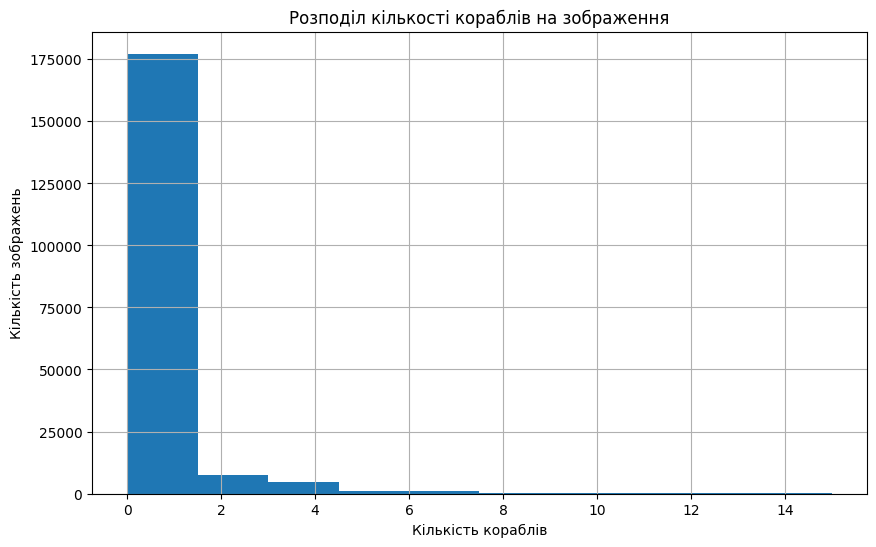

In [33]:
df['ships_count'] = df.groupby('ImageId')['EncodedPixels'].transform('count')

# Візуалізація розподілу кількості кораблів
ship_counts = df.groupby('ImageId')['ships_count'].max()
plt.figure(figsize=(10, 6))
ship_counts.hist(bins=10)
plt.title('Розподіл кількості кораблів на зображення')
plt.xlabel('Кількість кораблів')
plt.ylabel('Кількість зображень')
plt.show()

In [34]:
# Фільтрація зображень без кораблів
df = df.dropna(subset=['EncodedPixels']).reset_index(drop=True)
print("Кількість зображень з кораблями:", df['ImageId'].nunique())

Кількість зображень з кораблями: 42556


In [35]:
!pip install segmentation-models-pytorch

In [37]:
from sklearn.model_selection import train_test_split

# Розділення ImageId на тренувальну та тестову вибірки
train_ids, test_ids = train_test_split(dataset.image_ids, test_size=0.2, random_state=42)

# Створення DataFrame для тренувальних і тестових даних
train_df = df_cleaned[df_cleaned['ImageId'].isin(train_ids)]
test_df = df_cleaned[df_cleaned['ImageId'].isin(test_ids)]


In [38]:
from torch.utils.data import DataLoader

# Тренувальний датасет
train_dataset = ShipDataset(image_ids=train_ids, df_cleaned=train_df, images_path=images_path)

# Тестовий датасет
test_dataset = ShipDataset(image_ids=test_ids, df_cleaned=test_df, images_path=images_path)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)


In [39]:
!pip install segmentation-models-pytorch


In [40]:
import segmentation_models_pytorch as smp
import torch

# Створення моделі UNet
model = smp.Unet(
    encoder_name="resnet34",  # Основна архітектура
    encoder_weights="imagenet",  # Попередньо натреновані ваги
    in_channels=3,  # Кількість каналів на вході (RGB)
    classes=1,  # Кількість класів (1 для бінарної сегментації)
)

model


Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [50]:
# Втрата та оптимізатор
loss_fn = smp.losses.DiceLoss(mode="binary")
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [51]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Тренувальний цикл
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    
    for images, masks in train_loader:
        # Переносимо на пристрій
        images = images.to(device)  # Розмір (batch_size, channels, height, width)
        masks = masks.to(device)    # Розмір (batch_size, 1, height, width)

        # Forward
        optimizer.zero_grad()
        outputs = model(images)  # Розмір (batch_size, 1, height, width)
        loss = loss_fn(outputs, masks)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {train_loss / len(train_loader):.4f}")




Epoch 1/10, Loss: 0.1838
Epoch 2/10, Loss: 0.1774


KeyboardInterrupt: 

In [ ]:
num_epochs = 10
train_loss_history = []
val_loss_history = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    
    # Тренувальний крок
    for images, masks in train_loader:
        # Переносимо на пристрій
        images = images.to(device)
        masks = masks.to(device)

        # Обчислення forward проходу
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, masks)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss_avg = train_loss / len(train_loader)
    train_loss_history.append(train_loss_avg)

    # Оцінка на валідаційних даних
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, masks in test_loader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            loss = loss_fn(outputs, masks)
            val_loss += loss.item()

    val_loss_avg = val_loss / len(val_loader)
    val_loss_history.append(val_loss_avg)

    # Виведення результатів кожного етапу
    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {train_loss_avg:.4f}, "
          f"Validation Loss: {val_loss_avg:.4f}")

# # Зберігаємо модель після тренування
# torch.save(model.state_dict(), 'unet_model.pth')

# # Виведення часу тренування
# print(f"Training completed in: {time.time() - start_time:.2f} seconds")